# parcels regions

runs parcels on existing netcdf files

In [1]:
%matplotlib inline

In [2]:
import math
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from parcels import FieldSet, ParticleSet
from parcels import AdvectionRK4
from datetime import timedelta, datetime

In [3]:
DATA_6KM = 6
DATA_2KM = 2
DATA_1KM = 1

filename_dict = {
    DATA_6KM: "west_coast_6km_hourly",
    DATA_2KM: "west_coast_2km_hourly",
    DATA_1KM: "west_coast_1km_hourly"
}

def get_file_info(name, path, res):
    xrds = xr.open_dataset(path)
    # spherical mesh
    fs = FieldSet.from_xarray_dataset(
            xrds.copy(deep=True),
            dict(U="u",V="v"),
            dict(lat="lat",lon="lon",time="time"),
        )
    xrds.close()
    lat = xrds["lat"].values
    lon = xrds["lon"].values
    return dict(
        name = name,
        path = path,
        res = res,
        xrds = xrds,
        fs = fs,
        timerng = (xrds["time"].min().values, xrds["time"].max().values),
        timerng_secs = fs.gridset.dimrange("time"),
        lat = lat,
        lon = lon,
        domain = {
            "S": lat.min(),
            "N": lat.max(),
            "W": lon.min(),
            "E": lon.max(),
        }
    )

### netcdf files

due to the lack of unique configurations for each file, there are limitations
- must have same time domain
- a domain that contains the defined spawn points later in the notebook

In [4]:
files = [
    get_file_info("tijuana_lin", "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_lin.nc", DATA_1KM),
    get_file_info("tijuana_invdist", "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_invdist.nc", DATA_1KM),
]

## Animated gif stuff and particle simulation

runs on each file you give it

In [5]:
# animation man very cool
# reference tutorial_Agulhasparticles
# needs ErrorCode for particle recovery
from operator import attrgetter
from parcels import ErrorCode, JITParticle, Variable

max_v = 1.1 # for display purposes only, so the vector field colors don't change every iteration

class TimedParticle(JITParticle):
    lifetime = Variable("lifetime", initial=0, dtype=np.float32)
    spawntime = Variable("spawntime", initial=attrgetter("time"), dtype=np.float32)
    
def ParticleLifetime(particle, fieldset, time):
    particle.lifetime += particle.dt

def DeleteParticle(particle, fieldset, time):
    particle.delete()
    
def exec_save_pset(pset, path, runtime, dt):
    pset.show(savefile=path, field='vector', land=True, vmax=max_v)
    
    # temporary - TODO make it only init once
    k_plifetime = pset.Kernel(ParticleLifetime)
    
    pset.execute(AdvectionRK4 + k_plifetime,
                 runtime=timedelta(seconds=runtime),
                 dt=timedelta(seconds=dt),
                 recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

### set up particle spawn points

currently works where particles are generated at random positions with a bit of variations, and are released at set intervals.

note about interpolation methods: only `linear` works if you want to use the FieldSet in a ParticleSet.

TODO move simulation configurations somewhere else so its unique for every dataset

In [6]:
repeat_dt = timedelta(hours=4) # interval at which particles are released
particles_per_dt = 10 # number of particles to release at each interval
max_variation = 0.0015 # the max degrees a particle can be away from a spawn point

# TODO: spawn points should probably be saved with a netcdf file
spawn_points = np.array([
#     (32.551707, -117.136)
    (32.551707, -117.138),
    (32.557, -117.138)
])

/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:188: RuntimeWarning: invalid value encountered in true_divide
  v = np.where(speed > 0., data[1]/speed, 0)


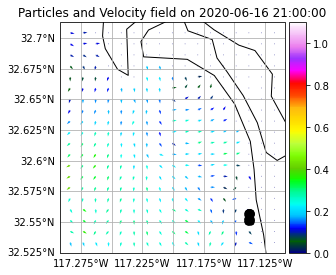

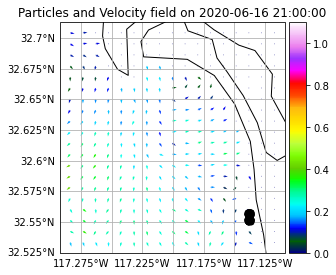

In [7]:
# NOTE same spawns for every dataset currently
for f in files:
    repetitions = math.floor(f["timerng_secs"][1] / repeat_dt.total_seconds())
    total = repetitions * particles_per_dt
    lat_arr = np.zeros(total)
    lon_arr = np.zeros(total)
    time_arr = np.zeros(total)
    for i in range(repetitions):
        time_arr[particles_per_dt * i:particles_per_dt * (i + 1)] = repeat_dt.seconds * i

    sp_lat = spawn_points.T[0][np.random.randint(0, len(spawn_points), total)]
    sp_lon = spawn_points.T[1][np.random.randint(0, len(spawn_points), total)]
    variances_lat = (np.random.random(total) * 2 - 1) * max_variation
    variances_lon = (np.random.random(total) * 2 - 1) * max_variation

    p_lats = sp_lat + variances_lat
    p_lons = sp_lon + variances_lon

    f["pset"] = ParticleSet(fieldset=f["fs"], pclass=TimedParticle, lon=p_lons, lat=p_lats, time=time_arr)
    f["pset"].show(field="vector", vmax=max_v)

In [8]:
import os
from pathlib import Path

snapshot_interval = 3600 * 3 # seconds
p_dt = 300 # seconds

clear_directories = True

for f in files:
    f["snap_num"] = math.floor((f["timerng_secs"][1] - f["timerng_secs"][0]) / snapshot_interval)
    f["last_int"] = f["timerng_secs"][1] - f["snap_num"] * snapshot_interval
    if f["last_int"] == 0:
        print(f"Num snapshots to save for {f['path']}: {f['snap_num'] + 1}")
    else:
        print(f"Num snapshots to save for {f['path']}: {f['snap_num'] + 2}")
    f["snap_path"] = Path(f"snapshots_{filename_dict[f['res']]}/{f['name']}")
    f["snap_path"].mkdir(parents=True, exist_ok=True)
    print(f"Path to save snapshots to: {f['snap_path']}")
    if clear_directories:
        for p in f["snap_path"].glob("*.png"):
            p.unlink()

Num snapshots to save for west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_lin.nc: 57
Path to save snapshots to: snapshots_west_coast_1km_hourly/tijuana_lin
Num snapshots to save for west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river_invdist.nc: 57
Path to save snapshots to: snapshots_west_coast_1km_hourly/tijuana_invdist


In [9]:
for f in files:
    for i in range(f["snap_num"]):
        exec_save_pset(f["pset"], str(f["snap_path"])+"/particles"+str(i).zfill(3), snapshot_interval, p_dt)

    # save the second-to-last frame
    f["pset"].show(savefile=str(f["snap_path"])+"/particles"+str(f["snap_num"]).zfill(3), field='vector', vmax=max_v)

    # run the last interval (the remainder) if needed
    if f["last_int"] != 0:
        exec_save_pset(f["pset"], str(f["snap_path"])+"/particles"+str(f["snap_num"] + 1).zfill(3), f["last_int"], p_dt)

print("all simulations done and snapshots saved")

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles000.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/4bd70b89585e32828571a98bc5dd8a6d_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles007.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/db1bfe4b33cd2b054a38937d257e7030_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles014.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/0090dadc9cabc7a7dae55ce47c1a9ce2_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles021.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/bc1884b809112287cea1ff799e58e293_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles028.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/4f80b55f8ca8458171f270bdb6f85fa2_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles035.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/8ab3f3d008ea96cbe1483f88df13e204_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles042.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/caf5b46d55aa7cb038978005ffa2e8d0_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles049.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/321d6522770f6070f01892ee60e9259b_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Users/

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_lin/particles056.png
INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles000.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/d6da3212655600e793700d50c9ebb37e_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid 

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles007.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/61b43f00b2165158f22e2971a1f7999a_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles014.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/9a4881531519e62f7ff8b2b4f861d97b_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles021.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/0b0e2924dc38541b20556ce54edab04a_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles028.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/242e51a109528e7398856e3c2801b39c_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles035.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/f4b82e999388db276617b50f15cada60_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles042.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/a689a6886c9333adc1ab6bbc5a218981_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles049.png
INFO: Compiled TimedParticleAdvectionRK4ParticleLifetime ==> /var/folders/mb/hd5ymr3137g2g0chv_x_tvb40000gq/T/parcels-503/2eadee6cc6ce9036d419c11ec280cef6_0.so
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/parcels/plotting.py:187: RuntimeWarning: invalid value encountered in true_divide
  u = np.where(speed > 0., data[0]/speed, 0)
/Us

INFO: Plot saved to snapshots_west_coast_1km_hourly/tijuana_invdist/particles056.png


all simulations done and snapshots saved


### gif generation

don't have to run, requires [magick](https://imagemagick.org/index.php)

the gifs will be saved `snapshots_west_coast_xkm_hourly/` where xkm is the resolution

In [10]:
import subprocess

gif_delay = 25 # ms

for f in files:
    magick_sp = subprocess.Popen(["magick", "-delay", str(gif_delay), str(f["snap_path"]) + "/*.png", f"snapshots_{filename_dict[f['res']]}/partsim_{f['name']}.gif"], 
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE,
                                   universal_newlines=True)
    stdout, stderr = magick_sp.communicate()
    print((stdout, stderr))

('', '')
('', '')
